Using device: cuda


<ipython-input-1-d606f3ab7594>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or

Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

<ipython-input-1-d606f3ab7594>:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

<ipython-input-1-d606f3ab7594>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/40 [00:00<?, ?it/s]


Test Accuracy: 82.18%

Confusion Matrix:
 [[830  18  25  13  13   1   5   4  58  33]
 [ 10 890   3   5   0   2   3   4  15  68]
 [ 24   1 761  45  70  23  51  13   7   5]
 [  7  10  35 707  44 111  45  24   9   8]
 [  7   3  35  36 803  18  35  55   7   1]
 [  3   3  22 135  34 745  16  34   1   7]
 [  6   2  34  45  37  13 858   2   1   2]
 [ 14   2  24  19  70  33   6 825   4   3]
 [ 43  30   4   4   1   1   3   0 899  15]
 [ 16  54   3   3   1   1   0   4  18 900]]

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1000
           1       0.88      0.89      0.88      1000
           2       0.80      0.76      0.78      1000
           3       0.70      0.71      0.70      1000
           4       0.75      0.80      0.77      1000
           5       0.79      0.74      0.76      1000
           6       0.84      0.86      0.85      1000
           7       0.85      0.82      0.84      1000
           8  

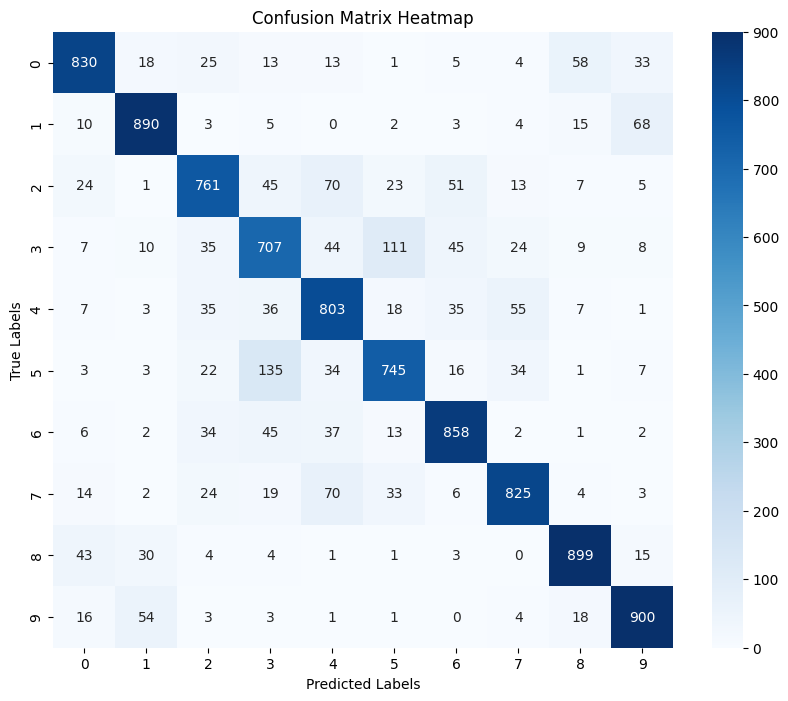

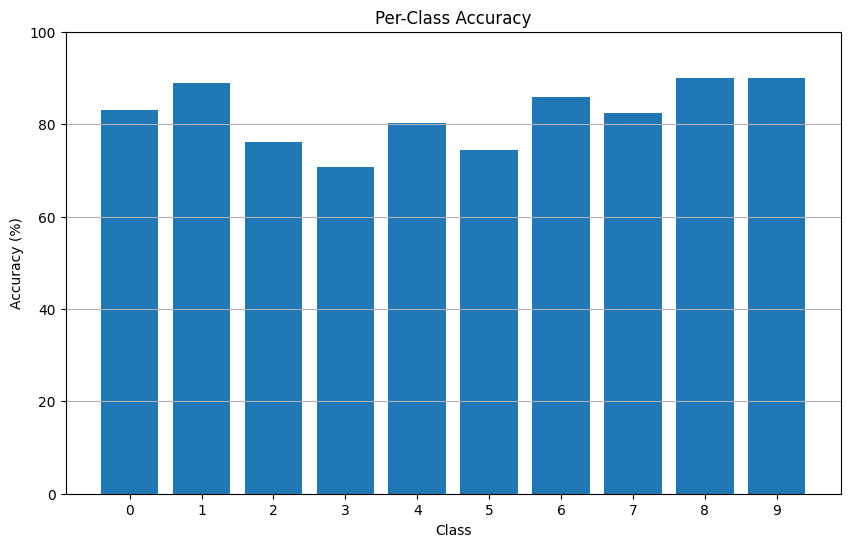

In [1]:
# %% Install Requirements
!pip install -q torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.auto import tqdm
import time

# Enable GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mixed precision setup
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True
# %% Data Pipeline
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,
                         num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,
                        num_workers=4, pin_memory=True)
# %% Model Architecture
from torchvision import models

model = models.alexnet(pretrained=True)  # Trained on ImageNet-1K

import torch.nn as nn

model.classifier[6] = nn.Linear(4096, 10)
for params in model.parameters():
  params.requires_grad=False
for param in model.classifier[6].parameters():
    param.requires_grad = True
model.to(device)
# %% Training Configuration
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                        steps_per_epoch=len(train_loader),
                                        epochs=5)
criterion = nn.CrossEntropyLoss()

# %% Training Execution
from torch.cuda.amp import GradScaler,autocast
scaler=GradScaler()
for epoch in range(5):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        pbar.set_postfix(loss=loss.item())
        scheduler.step()
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Put model in eval mode
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

# Evaluation with no gradients
with torch.no_grad(), torch.cuda.amp.autocast():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", conf_matrix)

# Classification Report (precision, recall, f1-score)
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=2))

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Per-class accuracy
conf_matrix = np.array(conf_matrix)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(class_accuracy)), class_accuracy * 100)
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy")
plt.xticks(np.arange(len(class_accuracy)))
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()